In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import mne
import scipy.signal as signal



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.svm import SVC  # SVM classifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
file = pd.read_csv(r"D:\Clg\Project\SDP 2\dataset\16\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001_sleepscoring.txt")

# print(file.shape[0])
# print(file.head())
print(file.columns)
print(file[" Annotation"][0])

print(file[' Annotation'].unique())


Index(['Date', ' Time', ' Recording onset', ' Duration', ' Annotation',
       ' Linked channel'],
      dtype='object')
 Sleep stage W
[' Sleep stage W' ' Lights off' ' Sleep stage N1' ' Sleep stage N2'
 ' Sleep stage N3' ' Sleep stage R' ' Lights on']


In [24]:
text_files = []
edf_files = []
target_map = {'N1' : 1, 'N2' : 2, 'N3' : 3, 'W' : 4, 'R' : 5}
no_of_files = 1

path = r"D:\Clg\Project\SDP 2\dataset\16\physionet.org\files\hmc-sleep-staging\1.0.0\recordings"

for i in range(1, no_of_files+1):
    text_file_name = f"\SN00{i}_sleepscoring.txt"
    edf_file_name = f"\SN00{i}.edf"

    txt_file = pd.read_csv(path + text_file_name)
    text_files.append(txt_file)

    edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)
    
    edf_file = edf_file.pick(['EEG C4-M1'])

    time = edf_file.times[-1] - 150
    s, e = 0 + 150, 30 + 150
    idx = 0 + 5

    dic = {}

    while e < time and idx < txt_file.shape[0]:
        stage = txt_file[" Annotation"][idx].split(" ")[-1]

        if stage in target_map:
            dic[s] = [edf_file.copy().crop(tmin=s, tmax=e), stage]
        idx += 1
        s = e
        e += 30

    edf_files.append(dic)

print(len(text_files))

C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_5764\3188155077.py:15: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)
C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_5764\3188155077.py:15: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  edf_file = mne.io.read_raw_edf(path + edf_file_name, preload= True)


1


Delta band extraction

In [4]:
mne.set_log_level("warning")

def _filter(_signal):
    delta_band, times = _signal[:]

    low, high = 0.5, 4

    fs = _signal.info['sfreq']

    b, a = signal.butter(3, [low, high], btype='bandpass', fs=fs)

    filtered_signal = signal.filtfilt(b, a, delta_band[0])

    return filtered_signal

# bands = _filter(dic[150][0])
# print(bands)
# print(len(bands))
# for band in bands:
#     temp = band

#     print(temp,'\n')

In [36]:
butter_worth, butter_target = [], []

for i in range(len(edf_files)): 
    dic = edf_files[i]
    for idx, val in dic.items():

        temp = _filter(val[0])

        butter_worth.append(temp)
        butter_target.append(target_map[val[1]])


print(len(butter_worth), len(butter_target))
print(set(butter_target))
# print(butter_worth[0])
# print(butter_worth[1])


# Ensure butter_worth and butter_target are numpy arrays
butter_worth = np.array(butter_worth)
butter_target = np.array(butter_target)

print(butter_target.shape)
print(butter_worth.shape)


844 844
{1, 2, 3, 4, 5}
(844,)
(7681,)


In [6]:
# ! pip install tenserflow


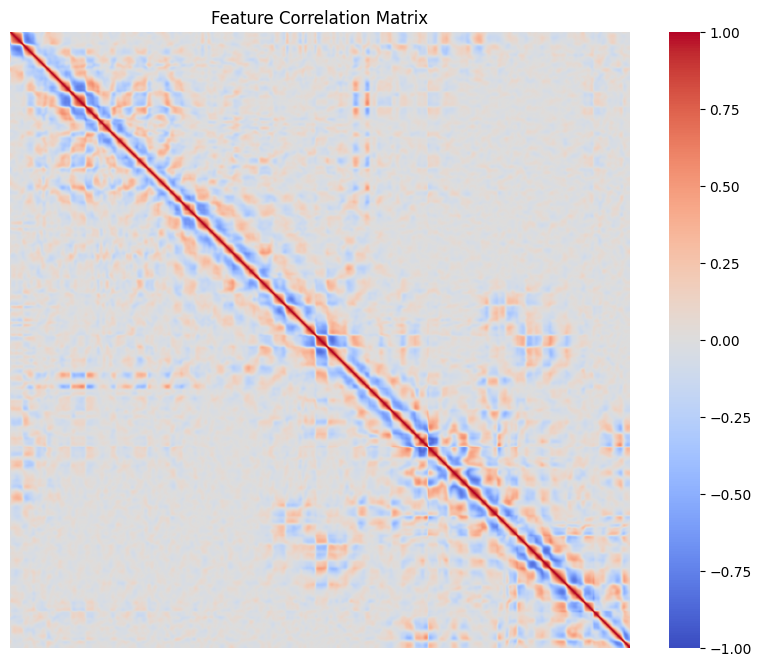

In [39]:
import seaborn as sns

correlation_matrix = np.corrcoef(butter_worth, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=False, yticklabels=False)  # Disable ticks for large matrix
plt.title("Feature Correlation Matrix")
plt.show()


LSTM model

LSTM

In [26]:
# Check dimensions before reshaping
print("Original shapes:")
print("butter_worth:", butter_worth.shape)
print("butter_target:", butter_target.shape)

# Reshape butter_worth to 3D (samples, timesteps, features)
# Assuming each sample has 7681 features and we treat it as 1 timestep
butter_worth_reshaped = butter_worth.reshape((butter_worth.shape[0], 1, butter_worth.shape[1]))

# Check the reshaped dimensions
print("Reshaped butter_worth:", butter_worth_reshaped.shape)

Original shapes:
butter_worth: (844, 7681)
butter_target: (844,)
Reshaped butter_worth: (844, 1, 7681)


In [27]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(butter_worth_reshaped, butter_target, test_size=0.2, random_state=42)

# Print shapes to verify correctness
print("Train and test set shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))  # Adjust input shape to match X_train
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

# Making predictions
predictions = model.predict(X_test)

# Example output
print(f'\nExample Predictions: {predictions[:5]}')


Train and test set shapes:
X_train: (675, 1, 7681)
X_test: (169, 1, 7681)
y_train: (675,)
y_test: (169,)
Epoch 1/10
22/22 [==============================] - 3s 47ms/step - loss: 0.6375 - accuracy: 0.1230 - val_loss: 0.5679 - val_accuracy: 0.1420
Epoch 2/10
22/22 [==============================] - 1s 29ms/step - loss: 0.5010 - accuracy: 0.1259 - val_loss: 0.4150 - val_accuracy: 0.1420
Epoch 3/10
22/22 [==============================] - 1s 26ms/step - loss: 0.3315 - accuracy: 0.1259 - val_loss: 0.2246 - val_accuracy: 0.1420
Epoch 4/10
22/22 [==============================] - 1s 28ms/step - loss: 0.1172 - accuracy: 0.1259 - val_loss: -0.0171 - val_accuracy: 0.1420
Epoch 5/10
22/22 [==============================] - 1s 28ms/step - loss: -0.1504 - accuracy: 0.1259 - val_loss: -0.3063 - val_accuracy: 0.1420
Epoch 6/10
22/22 [==============================] - 1s 26ms/step - loss: -0.4700 - accuracy: 0.1259 - val_loss: -0.6567 - val_accuracy: 0.1420
Epoch 7/10
22/22 [==========================

SVR model

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(butter_worth, butter_target, test_size=0.2, random_state=42)

# Create and train the SVM model (linear kernel)
model = SVC(kernel='linear')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy: 48.52%
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.49      1.00      0.65        82
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        25

    accuracy                           0.49       169
   macro avg       0.10      0.20      0.13       169
weighted avg       0.24      0.49      0.32       169



C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Load dataset (Iris dataset as an example)
data = load_iris()
X = data.data  # Features
y = data.target  # Target (classes)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(butter_worth, butter_target, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Feature importance
importances = clf.feature_importances_
print(f'Feature Importances: {importances}')


Accuracy: 49.70%
Feature Importances: [2.64089935e-04 0.00000000e+00 0.00000000e+00 ... 4.25582164e-04
 3.90798171e-05 6.46229345e-05]
